**Name:** Veljko Kovac

In [3]:
# %matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
# IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import math

## 1. Loading Data and Pre-processing


In [2]:
imgdata = []
genders = []

# load the zip file
filename = 'photos-bw.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "photos-bw/*.png"):
        print("loading", name)
        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        img = matplotlib.image.imread(myfile)
        myfile.close()
        
        # append to data
        imgdata.append(img)
        genders.append( int(name[len("photos-bw/")] == 'm') )  # 0 is female, 1 is male
        
zfile.close()
imgsize = img.shape
print("DONE: loaded {} images".format(len(imgdata)))

loading photos-bw/f-039-01.png
loading photos-bw/f-040-01.png
loading photos-bw/f-041-01.png
loading photos-bw/f-042-01.png
loading photos-bw/f-043-01.png
loading photos-bw/f1-001-0.png
loading photos-bw/f1-002-0.png
loading photos-bw/f1-003-0.png
loading photos-bw/f1-004-0.png
loading photos-bw/f1-005-0.png
loading photos-bw/f1-006-0.png
loading photos-bw/f1-007-0.png
loading photos-bw/f1-008-0.png
loading photos-bw/f1-009-0.png
loading photos-bw/f1-010-0.png
loading photos-bw/f1-011-0.png
loading photos-bw/f1-012-0.png
loading photos-bw/f1-013-0.png
loading photos-bw/f1-014-0.png
loading photos-bw/f1-015-0.png
loading photos-bw/m-063-01.png
loading photos-bw/m-064-01.png
loading photos-bw/m-065-01.png
loading photos-bw/m-067-01.png
loading photos-bw/m-069-01.png
loading photos-bw/m-070-01.png
loading photos-bw/m-073-01.png
loading photos-bw/m-074-01.png
loading photos-bw/m-075-01.png
loading photos-bw/m-077-01.png
loading photos-bw/m-083-01.png
loading photos-bw/m-085-01.png
loading 

Each image is a 45x40 array of pixel values.

(45, 40)


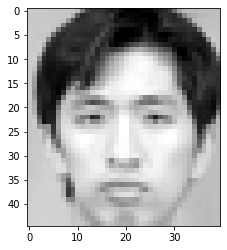

In [3]:
print(img.shape)
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.show()

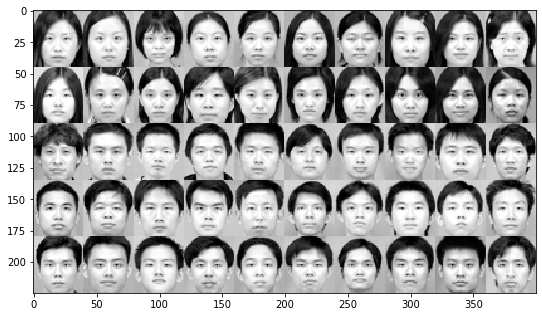

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
X = empty((50, prod(imgdata[0].shape))) # create empty array
for i,img in enumerate(imgdata):
    X[i,:] = ravel(img)           # for each image, turn it into a vector
Y = asarray(genders)  # convert list to numpy array
print(X.shape)
print(Y.shape)

(50, 1800)
(50,)


Next we will shift the pixel values so that gray is 0.0, black is -0.5 and white is 0.5.

In [6]:
print("Before: min={}, max={}".format(X.min(), X.max()))
X -= 0.5
print("After:  min={}, max={}".format(X.min(), X.max()))

Before: min=0.0, max=1.0
After:  min=-0.5, max=0.5


Finally, split the dataset into a training set and testing set. We select 80% for training and 20% for testing.

In [7]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(40, 1800)
(10, 1800)


## 2. Logistic Regression
Train a logistic regression classifier. 

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegressionCV
Cs = logspace(-4, 4, 20)
log_reg = LogisticRegressionCV(Cs = Cs,cv = 5, random_state = 0, multi_class = 'multinomial')

clf = log_reg.fit(trainX, trainY)


In [9]:
pred_Y_train = log_reg.predict(trainX)
pred_Y_test = log_reg.predict(testX)
acc = metrics.accuracy_score(testY, pred_Y_test)
print("Train accuracy = "+ str(metrics.accuracy_score(trainY, pred_Y_train)))
print("Test accuracy = "+str(acc))

Train accuracy = 0.9
Test accuracy = 0.8


### 2.1 Analyzing the classifier


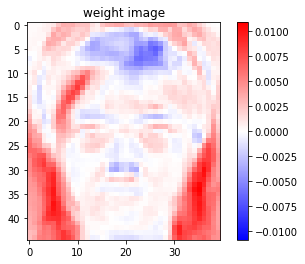

In [10]:
# logreg is the learned logistic regression model
wimg = log_reg.coef_.reshape(imgsize)      # get the w and reshape into an image
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#FFFFFF", "#FF0000"])
mm = max(wimg.max(), -wimg.min())
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("weight image")
plt.show()

In order for $f(\mathbf{x})$ to be positive, then the positive values of the weight image (red regions) should match the positive values in the face image (white pixels), and the negative values of the weight image (blue regions) should be matched with negative values in the face image (black pixels).

Hence, we can have the following interpretation:
<table>
<tr><th>Class</th><th>red regions (positive weights)</th><th>blue regions (negative weights)</th><th>white regions (weights near 0)</th></tr>
<tr><td>+1 class (male)</td><td>white pixels in face image</td><td>black pixels in face image</td><td>region not important</td></tr>
<tr><td>-1 class (female)</td><td>black pixels in face image</td><td>white pixels in face image</td><td>region not important</td></tr>
</table>

Now let's look at the misclassified faces in the test set.  Run the below code to show the misclassifed and correctly classified faces.

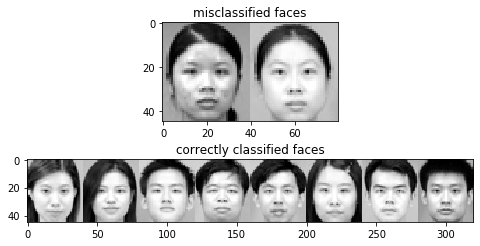

In [11]:
# predYtest are the class predictions on the test set.
# find misclassified test images
inds = where(pred_Y_test != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(pred_Y_test == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()

The misclassified faces are females where the hair is pulled back and not on the side of the face. So to the classifier, they look like male faces.

## 3. Naive Bayes
Next, we train a naive bayes (NB).

In [12]:
from sklearn.naive_bayes import GaussianNB
mnb = GaussianNB()
mnb_fit = mnb.fit(trainX, trainY)
pred_testY_mnb = mnb.predict(testX)
pred_trainY_mnb = mnb.predict(trainX)
acc = metrics.accuracy_score(testY, pred_testY_mnb)
print("Train accuracy = "+ str(metrics.accuracy_score(trainY, pred_trainY_mnb)))
print(acc)

Train accuracy = 0.975
0.9


Now let's also look at the misclassified faces in the test set. To show the misclassifed and correctly classified faces like above.

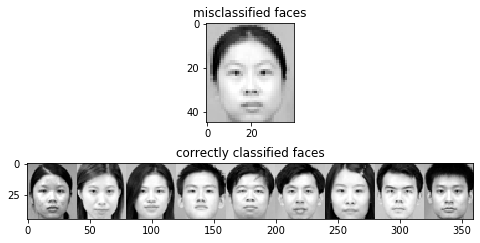

In [13]:
# predYtest are the class predictions on the test set.
# find misclassified test images
inds = where(pred_testY_mnb != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(pred_testY_mnb == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()

## 4. K Nearest Neighbor


In [14]:
knn = neighbors.KNeighborsClassifier()
paramgrid = {'n_neighbors': [3,5,10]}
clf = model_selection.GridSearchCV(knn, paramgrid, cv=5, n_jobs=-1, scoring = 'accuracy')


In [15]:
clf.fit(trainX, trainY)
# predict from the model
predYtrain = clf.predict(trainX)
predYtest = clf.predict(testX)

# calculate accuracy
acc      = metrics.accuracy_score(trainY, predYtrain)
print("train accuracy =", acc)

# calculate accuracy
acc      = metrics.accuracy_score(testY, predYtest)
print("test accuracy  =", acc)

train accuracy = 0.875
test accuracy  = 0.8


Now let's also look at the misclassified faces in the test set. 

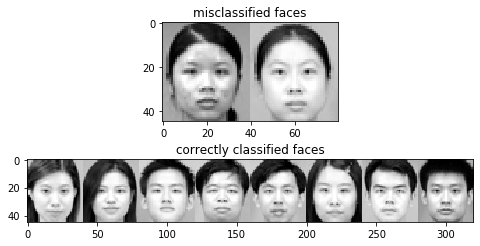

In [16]:
# predYtest are the class predictions on the test set.

# find misclassified test images
inds = where(predYtest != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predYtest == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()